# Multi-view consistency tests

In [1]:
# Select you GPU
I_GPU = 0

# Uncomment to use autoreload
%load_ext autoreload
%autoreload 2

import os
import os.path as osp
import sys
import torch
import numpy as np
from time import time
from omegaconf import OmegaConf
from PIL import Image
start = time()
import warnings
warnings.filterwarnings('ignore')

# torch.cuda.set_device(I_GPU)
DIR = os.path.dirname(os.getcwd())
ROOT = os.path.join(DIR, "..")
sys.path.insert(0, ROOT)
sys.path.insert(0, DIR)

from torch_points3d.utils.config import hydra_read
from torch_geometric.data import Data
from torch_points3d.core.multimodal.data import MMData, MMBatch
from torch_points3d.visualization.multimodal_data import visualize_mm_data
from torch_points3d.core.multimodal.image import SameSettingImageData, ImageData
from torch_points3d.datasets.segmentation.multimodal.scannet import ScannetDatasetMM
from torch_points3d.datasets.segmentation.scannet import CLASS_COLORS, CLASS_NAMES, CLASS_LABELS
from torch_points3d.metrics.segmentation_tracker import SegmentationTracker

from pykeops.torch import LazyTensor

import plotly.io as pio

#pio.renderers.default = 'jupyterlab'        # for local notebook
pio.renderers.default = 'iframe_connected'  # for remote notebook. Other working (but seemingly slower) options are: 'sphinx_gallery' and 'iframe'

MMData debug() function changed, please uncomment the 3rd assert line when doing inference without M2F features!


In [2]:
import os
import torchnet as tnt
import torch
from typing import Dict, Any
import wandb
from torch.utils.tensorboard import SummaryWriter
import logging
from torch_points3d.metrics.confusion_matrix import ConfusionMatrix
from torch_points3d.models import model_interface
from torch_points3d.metrics.base_tracker import BaseTracker, meter_value
from torch_points3d.metrics.meters import APMeter
from torch_points3d.datasets.segmentation import IGNORE_LABEL

from torch_geometric.nn.unpool import knn_interpolate
from torch_points3d.core.data_transform import SaveOriginalPosId

log = logging.getLogger(__name__)


def meter_value(meter, dim=0):
    return float(meter.value()[dim]) if meter.n > 0 else 0.0


class BaseTracker:
    def __init__(self, stage: str, wandb_log: bool, use_tensorboard: bool):
        self._wandb = wandb_log
        self._use_tensorboard = use_tensorboard
        self._tensorboard_dir = os.path.join(os.getcwd(), "tensorboard")
        self._n_iter = 0
        self._finalised = False
        self._conv_type = None

        if self._use_tensorboard:
            log.info(
                "Access tensorboard with the following command <tensorboard --logdir={}>".format(self._tensorboard_dir)
            )
            self._writer = SummaryWriter(log_dir=self._tensorboard_dir)

    def reset(self, stage="train"):
        self._stage = stage
        self._loss_meters = {}
        self._finalised = False

    def get_metrics(self, verbose=False) -> Dict[str, Any]:
        metrics = {}
        for key, loss_meter in self._loss_meters.items():
            value = meter_value(loss_meter, dim=0)
            if value:
                metrics[key] = meter_value(loss_meter, dim=0)
        return metrics

    @property
    def metric_func(self):
        self._metric_func = {"loss": min}
        return self._metric_func

    def track(self, model: model_interface.TrackerInterface, **kwargs):
        if self._finalised:
            raise RuntimeError("Cannot track new values with a finalised tracker, you need to reset it first")
            
        if model is not None:
            losses = self._convert(model.get_current_losses())
            self._append_losses(losses)

    def finalise(self, *args, **kwargs):
        """ Lifcycle method that is called at the end of an epoch. Use this to compute
        end of epoch metrics.
        """
        self._finalised = True

    def _append_losses(self, losses):
        for key, loss in losses.items():
            if loss is None:
                continue
            loss_key = "%s_%s" % (self._stage, key)
            if loss_key not in self._loss_meters:
                self._loss_meters[loss_key] = tnt.meter.AverageValueMeter()
            self._loss_meters[loss_key].add(loss)

    @staticmethod
    def _convert(x):
        if torch.is_tensor(x):
            return x.detach().cpu().numpy()
        else:
            return x

    def publish_to_tensorboard(self, metrics, step):
        for metric_name, metric_value in metrics.items():
            metric_name = "{}/{}".format(metric_name.replace(self._stage + "_", ""), self._stage)
            self._writer.add_scalar(metric_name, metric_value, step)

    @staticmethod
    def _remove_stage_from_metric_keys(stage, metrics):
        new_metrics = {}
        for metric_name, metric_value in metrics.items():
            new_metrics[metric_name.replace(stage + "_", "")] = metric_value
        return new_metrics

    def publish(self, step):
        """ Publishes the current metrics to wandb and tensorboard
        Arguments:
            step: current epoch
        """
        metrics = self.get_metrics()

        if self._wandb:
            wandb.log(metrics, step=step)

        if self._use_tensorboard:
            self.publish_to_tensorboard(metrics, step)

        # Some metrics may be intended for wandb or tensorboard
        # tracking but not for final final model selection. Those are
        # the metrics absent from self.metric_func and must be excluded
        # from the output of self.publish
        current_metrics = {
            k: v
            for k, v in self._remove_stage_from_metric_keys(self._stage, metrics).items()
            if k in self.metric_func.keys()}

        return {
            "stage": self._stage,
            "epoch": step,
            "current_metrics": current_metrics,
        }

    def print_summary(self):
        metrics = self.get_metrics(verbose=True)
        log.info("".join(["=" for i in range(50)]))
        for key, value in metrics.items():
            log.info("    {} = {}".format(key, value))
        log.info("".join(["=" for i in range(50)]))

    @staticmethod
    def _dict_to_str(dictionnary):
        string = "{"
        for key, value in dictionnary.items():
            string += "%s: %.2f," % (str(key), value)
        string += "}"
        return string


class SegmentationTracker(BaseTracker):
    def __init__(
        self, dataset, stage="train", wandb_log=False, use_tensorboard: bool = False, ignore_label: int = IGNORE_LABEL
    ):
        """ This is a generic tracker for multimodal tasks.
        It uses a confusion matrix in the back-end to track results.
        Use the tracker to track an epoch.
        You can use the reset function before you start a new epoch

        Arguments:
            dataset  -- dataset to track (used for the number of classes)

        Keyword Arguments:
            stage {str} -- current stage. (train, validation, test, etc...) (default: {"train"})
            wandb_log {str} --  Log using weight and biases
        """
        super(SegmentationTracker, self).__init__(stage, wandb_log, use_tensorboard)
        self._num_classes = dataset.num_classes
        self._ignore_label = ignore_label
        self._dataset = dataset
        self.reset(stage)
        self._metric_func = {
            "miou": max,
            "macc": max,
            "acc": max,
            "loss": min,
            "map": max,
        }  # Those map subsentences to their optimization functions

    def reset(self, stage="train"):
        super().reset(stage=stage)
        self._confusion_matrix = ConfusionMatrix(self._num_classes)
        self._acc = 0
        self._macc = 0
        self._miou = 0
        self._miou_per_class = {}

    @staticmethod
    def detach_tensor(tensor):
        if torch.torch.is_tensor(tensor):
            tensor = tensor.detach()
        return tensor

    @property
    def confusion_matrix(self):
        return self._confusion_matrix.confusion_matrix

    def track(self, model: model_interface.TrackerInterface, pred_labels=None, gt_labels=None, **kwargs):
        """ Add current model predictions (usually the result of a batch) to the tracking
        """
        if not self._dataset.has_labels(self._stage):
            return

        # Feng: to evaluate M2F predictions instead of model logits
        if pred_labels is not None and gt_labels is not None:
            outputs = pred_labels
            targets = gt_labels
        else:
            super().track(model)
            
            outputs = model.get_output()
            targets = model.get_labels()
        self._compute_metrics(outputs, targets)

    def _compute_metrics(self, outputs, labels):
        mask = labels != self._ignore_label
        outputs = outputs[mask]
        labels = labels[mask]

        outputs = self._convert(outputs)
        labels = self._convert(labels)

        if len(labels) == 0:
            return

        assert outputs.shape[0] == len(labels)
        
        # Check if output is predicted label or logits
        if len(outputs.shape) > 1:
            self._confusion_matrix.count_predicted_batch(labels, np.argmax(outputs, 1))
        else:
            
            self._confusion_matrix.count_predicted_batch(labels, outputs)

        self._acc = 100 * self._confusion_matrix.get_overall_accuracy()
        self._macc = 100 * self._confusion_matrix.get_mean_class_accuracy()
        self._miou = 100 * self._confusion_matrix.get_average_intersection_union()
        self._miou_per_class = {
            i: "{:.2f}".format(100 * v)
            for i, v in enumerate(self._confusion_matrix.get_intersection_union_per_class()[0])
        }

    def get_metrics(self, verbose=False) -> Dict[str, Any]:
        """ Returns a dictionnary of all metrics and losses being tracked
        """
        metrics = super().get_metrics(verbose)

        metrics["{}_acc".format(self._stage)] = self._acc
        metrics["{}_macc".format(self._stage)] = self._macc
        metrics["{}_miou".format(self._stage)] = self._miou

        if verbose:
            metrics["{}_miou_per_class".format(self._stage)] = self._miou_per_class
        return metrics

    @property
    def metric_func(self):
        return self._metric_func


class ScannetSegmentationTracker(SegmentationTracker):
    def reset(self, stage="train"):
        super().reset(stage=stage)
        self._full_confusion_matrix = ConfusionMatrix(self._num_classes)
        self._raw_datas = {}
        self._votes = {}
        self._vote_counts = {}
        self._full_preds = {}
        self._full_acc = None

    def track(self, model: model_interface.TrackerInterface, full_res=False, pred_labels=None, gt_labels=None, **kwargs):
        """ Add current model predictions (usually the result of a batch) to the tracking
        """
        if pred_labels is not None and gt_labels is not None:
            super().track(model=None, pred_labels=pred_labels, gt_labels=gt_labels)
        else:
            super().track(model)

            # Set conv type
            self._conv_type = model.conv_type

            # Train mode or low res, nothing special to do
            if not full_res or self._stage == "train" or kwargs.get("data") is None:
                return

            data = kwargs.get("data", model.get_input())
            data = data.data if model.is_multimodal else data
            self._vote(data, model.get_output())

    def get_metrics(self, verbose=False) -> Dict[str, Any]:
        """ Returns a dictionnary of all metrics and losses being tracked
        """
        metrics = super().get_metrics(verbose)
        if self._full_acc:
            metrics["{}_full_acc".format(self._stage)] = self._full_acc
            metrics["{}_full_macc".format(self._stage)] = self._full_macc
            metrics["{}_full_miou".format(self._stage)] = self._full_miou
        return metrics

    def finalise(self, full_res=False, make_submission=False, **kwargs):
        if not full_res and not make_submission:
            return
        
        self._predict_full_res()

        # Compute full res metrics
        if self._dataset.has_labels(self._stage):
            for scan_id in self._full_preds:
                full_labels = self._raw_datas[scan_id].y
                # Mask ignored labels
                mask = full_labels != self._ignore_label
                full_labels = full_labels[mask]
                full_preds = self._full_preds[scan_id].cpu()[mask].numpy()
                self._full_confusion_matrix.count_predicted_batch(full_labels, full_preds)

            self._full_acc = 100 * self._full_confusion_matrix.get_overall_accuracy()
            self._full_macc = 100 * self._full_confusion_matrix.get_mean_class_accuracy()
            self._full_miou = 100 * self._full_confusion_matrix.get_average_intersection_union()
            
        # Save files to disk
        if make_submission and self._stage == "test":
            self._make_submission()

    def _make_submission(self):
        orginal_class_ids = np.asarray(self._dataset.train_dataset.valid_class_idx)
        path_to_submission = self._dataset.path_to_submission
        for scan_id in self._full_preds:
            full_pred = self._full_preds[scan_id].cpu().numpy().astype(np.int8)
            full_pred = orginal_class_ids[full_pred]  # remap labels to original labels between 0 and 40
            scan_name = self._raw_datas[scan_id].scan_name
            path_file = osp.join(path_to_submission, "{}.txt".format(scan_name))
            np.savetxt(path_file, full_pred, delimiter="/n", fmt="%d")

    def _vote(self, data, output):
        """ Populates scores for the points in data

        Parameters
        ----------
        data : Data
            should contain `pos` and `SaveOriginalPosId.KEY` keys
        output : torch.Tensor
            probablities out of the model, shape: [N,nb_classes]
        """
        id_scans = data.id_scan
        if id_scans.dim() > 1:
            id_scans = id_scans.squeeze()
        if self._conv_type == "DENSE":
            batch_size = len(id_scans)
            output = output.view(batch_size, -1, output.shape[-1])

        for idx_batch, id_scan in enumerate(id_scans):
            # First time we see this scan
            if id_scan not in self._raw_datas:
                raw_data = self._dataset.get_raw_data(self._stage, id_scan, remap_labels=True)
                self._raw_datas[id_scan] = raw_data
                self._vote_counts[id_scan] = torch.zeros(raw_data.pos.shape[0], dtype=torch.int)
                self._votes[id_scan] = torch.zeros((raw_data.pos.shape[0], self._num_classes), dtype=torch.float)
            else:
                raw_data = self._raw_datas[id_scan]

            batch_mask = idx_batch
            if self._conv_type != "DENSE":
                batch_mask = data.batch == idx_batch
            idx = data[SaveOriginalPosId.KEY][batch_mask]

            self._votes[id_scan][idx] += output[batch_mask].cpu()
            self._vote_counts[id_scan][idx] += 1

    def _predict_full_res(self):
        """ Predict full resolution results based on votes """
        for id_scan in self._votes:
            has_prediction = self._vote_counts[id_scan] > 0
            self._votes[id_scan][has_prediction] /= self._vote_counts[id_scan][has_prediction].unsqueeze(-1)

            # Upsample and predict
            full_pred = knn_interpolate(
                self._votes[id_scan][has_prediction],
                self._raw_datas[id_scan].pos[has_prediction],
                self._raw_datas[id_scan].pos,
                k=1,
            )
            self._full_preds[id_scan] = full_pred.argmax(-1)


In [5]:
# Set your dataset root directory, where the data was/will be downloaded
DATA_ROOT = '/project/fsun/dvata'

dataset_config = 'segmentation/multimodal/Feng/scannet-neucon-smallres-m2f-partial-subsampled'   
models_config = 'segmentation/multimodal/Feng/mvfusion'    # model family
model_name = 'MVFusion_3D_small'                       # specific model

overrides = [
    'task=segmentation',
    f'data={dataset_config}',
    f'models={models_config}',
    f'model_name={model_name}',
    f'data.dataroot={DATA_ROOT}',
]

cfg = hydra_read(overrides)
OmegaConf.set_struct(cfg, False)  # This allows getattr and hasattr methods to function correctly
cfg.data.load_m2f_masks = True   # load Mask2Former predicted masks

In [6]:
cfg.data.m2f_preds_dirname = 'm2f_masks'
cfg.data.n_views = 9 #cfg.models[model_name].backbone.transformer.n_views
print(cfg.data.n_views)

9


In [7]:
# Dataset instantiation
start = time()
dataset = ScannetDatasetMM(cfg.data)
# print(dataset)
print(f"Time = {time() - start:0.1f} sec.")

Load predicted 2D semantic segmentation labels from directory  m2f_masks
initialize train dataset
initialize val dataset
initialize test dataset
line 720 scannet.py: split == 'test'
Time = 1.4 sec.


In [8]:
mm_data = dataset.val_dataset[0]
# print(mm_data.modalities['image'][0].m2f_pred_mask_path)

In [9]:
from torch_points3d.models.model_factory import instantiate_model

# Set your parameters
checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/2022-12-07/12-07-34' # 3rd run

# Create the model
print(f"Creating model: {cfg.model_name}")
model = instantiate_model(cfg, dataset)

# Load the checkpoint and recover the model weights
checkpoint = torch.load(f'{checkpoint_dir}/{model_name}.pt', map_location='cpu')
model.load_state_dict_with_same_shape(checkpoint['models']['latest'], strict=False)

# Prepare the model for inference
model = model.eval().cuda()
print('Model loaded')

# Create a MMBatch and run inference
batch = MMBatch.from_mm_data_list([mm_data])

with torch.no_grad():
    print("input batch: ", batch)
    model.set_input(batch, model.device)
    model(batch)
    
# Recover the predicted labels for visualization
mm_data.data.pred = model.output.detach().cpu().argmax(1)

Creating model: MVFusion_3D_small
task:  segmentation.multimodal
tested_model_name:  MVFusion_3D_small
class_name:  MVFusionAPIModel
model_module:  torch_points3d.models.segmentation.multimodal.Feng.mvfusion_3d
name, cls of chosen model_cls:  MVFusionAPIModel <class 'torch_points3d.models.segmentation.multimodal.Feng.mvfusion_3d.MVFusionAPIModel'>
x feature dim:  {'FEAT': 3}
nc_in:  67
nc_in:  64
nc_in:  32
nc_in:  64
nc_in:  128
nc_in:  256
nc_in:  128
nc_in:  128
nc_in:  96
nc_in:  96
Model loaded
input batch:  MMBatch(
    data = Batch(batch=[97387], coords=[97387, 3], grid_size=[1], id_scan=[1], mapping_index=[97387], mvfusion_input=[70799, 9, 10], origin_id=[97387], pos=[97387, 3], ptr=[2], x=[97387, 3], y=[97387])
    image = ImageBatch(num_settings=1, num_views=100, num_points=97387, device=cpu)
)


# Multi-view consistency metric
## The analysis 

### Part 1: Compare baseline and MVFusion performance using only 2D-3D pixel-point correspondences.
- How to make comparison fair in an unbalanced data setting? Number of pixels in 2D >> number of points in 3D, and each 3D point has varying number of matches.

(a) just simply calculate mIoU of all projected pixels per 2D image, and compare with mIoU of projected 3D points to all images. In 2D mIoU! because that is our selling point

(b) compare 2D mIoU of predicted masks, and 2D mIoU of Nearest Neighbor interpolated projected predictions from 3D.
 - then, also calculate a multi-view consistency metric 


In [ ]:
# print(mm_data.modalities['image'][0].mappings.values[2][-3:])

# mm_data.modalities['image'][0].mappings.feature_map_indexing[2]

In [10]:
from torch_points3d.utils.multimodal import lexargsort
from torch_points3d.core.multimodal.csr import CSRData
import scipy.ndimage
import matplotlib.pyplot as plt

In [11]:
for x in mm_data.modalities['image'][0]:

    print(x.mappings.feature_map_indexing[0].shape)
    
    break

torch.Size([6937])


In [12]:
tracker_mvfusion = ScannetSegmentationTracker(dataset=dataset, stage='train', wandb_log=False, use_tensorboard=False, ignore_label=IGNORE_LABEL)
tracker_mvfusion_2d = ScannetSegmentationTracker(dataset=dataset, stage='train', wandb_log=False, use_tensorboard=False, ignore_label=IGNORE_LABEL)
tracker_m2f = ScannetSegmentationTracker(dataset=dataset, stage='train', wandb_log=False, use_tensorboard=False, ignore_label=IGNORE_LABEL)
tracker_m2f_2d = ScannetSegmentationTracker(dataset=dataset, stage='train', wandb_log=False, use_tensorboard=False, ignore_label=IGNORE_LABEL)

CLASS_COLORS[0] = (174.0, 199.0, 232.0)
CLASS_COLORS[-1] = (0, 0, 0)
CLASS_COLORS

[(174.0, 199.0, 232.0),
 (152.0, 223.0, 138.0),
 (31.0, 119.0, 180.0),
 (255.0, 187.0, 120.0),
 (188.0, 189.0, 34.0),
 (140.0, 86.0, 75.0),
 (255.0, 152.0, 150.0),
 (214.0, 39.0, 40.0),
 (197.0, 176.0, 213.0),
 (148.0, 103.0, 189.0),
 (196.0, 156.0, 148.0),
 (23.0, 190.0, 207.0),
 (247.0, 182.0, 210.0),
 (219.0, 219.0, 141.0),
 (255.0, 127.0, 14.0),
 (158.0, 218.0, 229.0),
 (44.0, 160.0, 44.0),
 (112.0, 128.0, 144.0),
 (227.0, 119.0, 194.0),
 (82.0, 84.0, 163.0),
 (0, 0, 0)]

input batch:  MMBatch(
    data = Batch(batch=[97387], coords=[97387, 3], grid_size=[1], id_scan=[1], mapping_index=[97387], mvfusion_input=[72520, 9, 10], origin_id=[97387], pos=[97387, 3], ptr=[2], x=[97387, 3], y=[97387])
    image = ImageBatch(num_settings=1, num_views=100, num_points=97387, device=cpu)
)


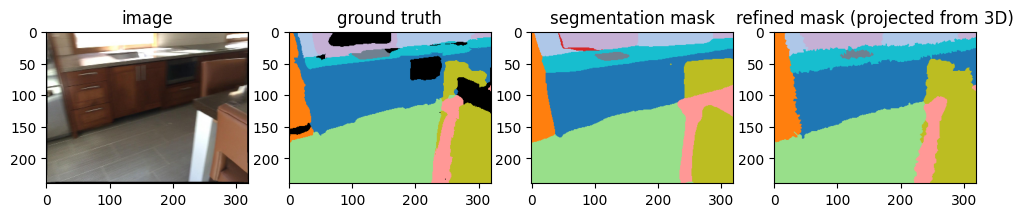

tensor([ 1,  1,  1,  ..., 14,  0,  0], dtype=torch.uint8)
tensor([[14, 14, 14,  ...,  8,  8,  8],
        [14, 14, 14,  ...,  8,  8,  8],
        [14, 14, 14,  ...,  8,  8,  8],
        ...,
        [ 1,  1,  1,  ...,  4,  4,  4],
        [ 1,  1,  1,  ...,  4,  4,  4],
        [ 1,  1,  1,  ...,  4,  4,  4]])


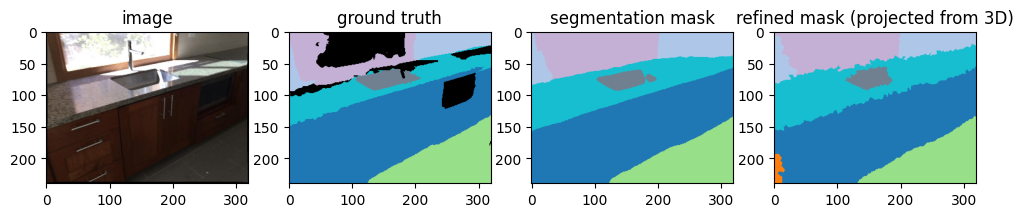

tensor([1, 1, 1,  ..., 8, 8, 8], dtype=torch.uint8)
tensor([[8, 8, 8,  ..., 0, 0, 0],
        [8, 8, 8,  ..., 0, 0, 0],
        [8, 8, 8,  ..., 0, 0, 0],
        ...,
        [2, 2, 2,  ..., 1, 1, 1],
        [2, 2, 2,  ..., 1, 1, 1],
        [2, 2, 2,  ..., 1, 1, 1]])


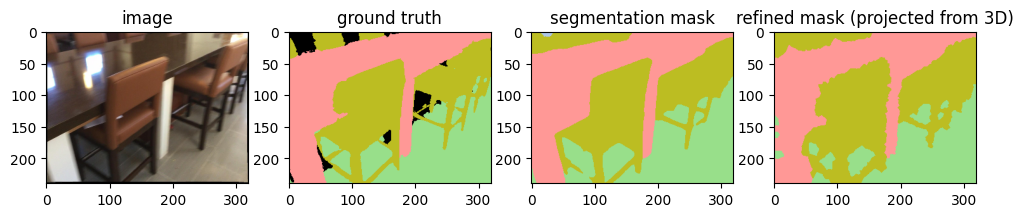

tensor([1, 1, 1,  ..., 6, 6, 6], dtype=torch.uint8)
tensor([[-1, -1, -1,  ...,  6,  6,  6],
        [-1, -1, -1,  ...,  6,  6,  6],
        [-1, -1, -1,  ...,  6,  6,  6],
        ...,
        [ 1,  1,  1,  ...,  1,  1,  1],
        [ 1,  1,  1,  ...,  1,  1,  1],
        [ 1,  1,  1,  ...,  1,  1,  1]])


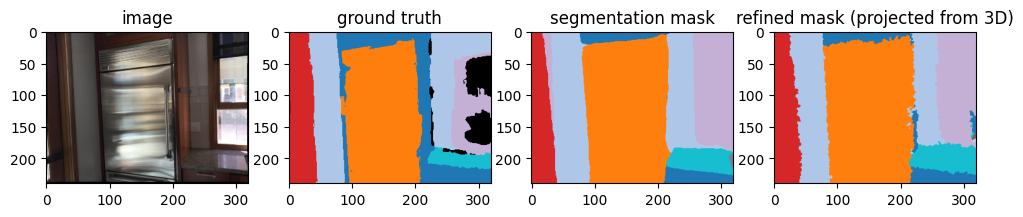

tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8)
tensor([[7, 7, 7,  ..., 0, 0, 0],
        [7, 7, 7,  ..., 0, 0, 0],
        [7, 7, 7,  ..., 0, 0, 0],
        ...,
        [7, 7, 7,  ..., 2, 2, 2],
        [7, 7, 7,  ..., 2, 2, 2],
        [7, 7, 7,  ..., 2, 2, 2]])


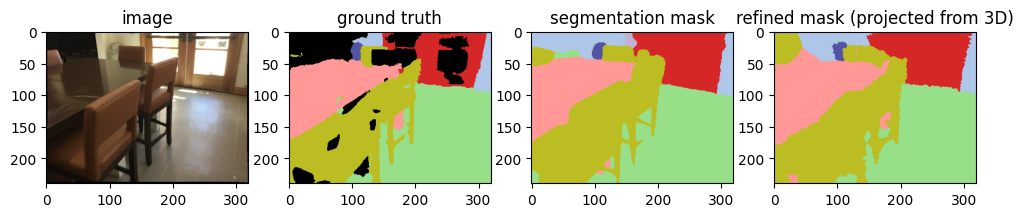

tensor([1, 1, 1,  ..., 0, 0, 0], dtype=torch.uint8)
tensor([[-1, -1, -1,  ...,  0,  0,  0],
        [-1, -1, -1,  ...,  0,  0,  0],
        [-1, -1, -1,  ...,  0,  0,  0],
        ...,
        [ 4,  4,  4,  ...,  1,  1,  1],
        [ 4,  4,  4,  ...,  1,  1,  1],
        [ 4,  4,  4,  ...,  1,  1,  1]])


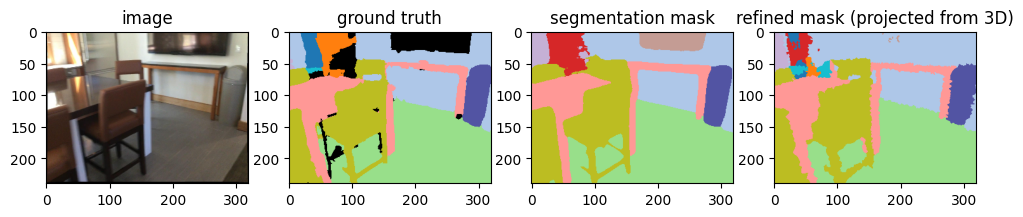

tensor([1, 1, 1,  ..., 8, 8, 8], dtype=torch.uint8)
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [4, 4, 4,  ..., 1, 1, 1],
        [4, 4, 4,  ..., 1, 1, 1],
        [4, 4, 4,  ..., 1, 1, 1]])


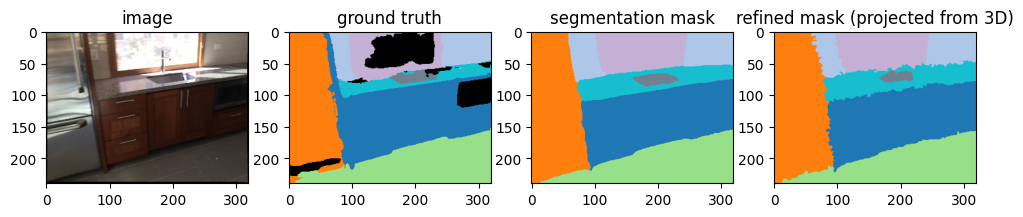

tensor([ 1,  1,  1,  ..., 14, 14, 14], dtype=torch.uint8)
tensor([[14, 14, 14,  ...,  0,  0,  0],
        [14, 14, 14,  ...,  0,  0,  0],
        [14, 14, 14,  ...,  0,  0,  0],
        ...,
        [14, 14, 14,  ...,  1,  1,  1],
        [14, 14, 14,  ...,  1,  1,  1],
        [14, 14, 14,  ...,  1,  1,  1]])


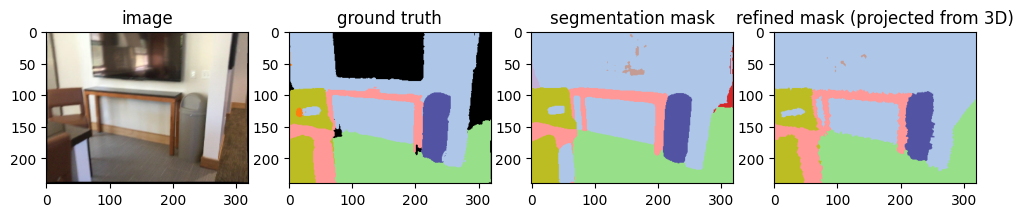

tensor([1, 1, 1,  ..., 0, 0, 0], dtype=torch.uint8)
tensor([[ 0,  0,  0,  ..., -1, -1, -1],
        [ 0,  0,  0,  ..., -1, -1, -1],
        [ 0,  0,  0,  ..., -1, -1, -1],
        ...,
        [ 4,  4,  4,  ...,  1,  1, -1],
        [ 4,  4,  4,  ...,  1,  1, -1],
        [ 4,  4,  4,  ..., -1, -1, -1]])


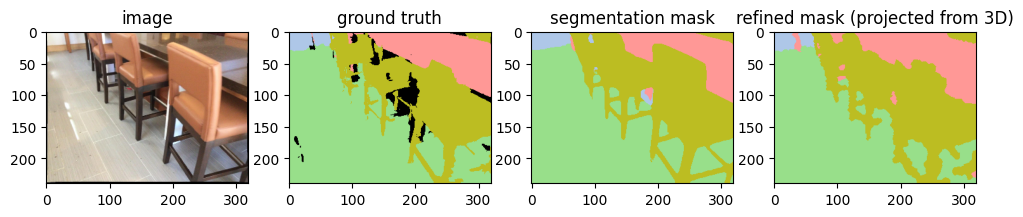

tensor([1, 1, 1,  ..., 4, 4, 4], dtype=torch.uint8)
tensor([[0, 0, 0,  ..., 4, 4, 4],
        [0, 0, 0,  ..., 4, 4, 4],
        [0, 0, 0,  ..., 4, 4, 4],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])


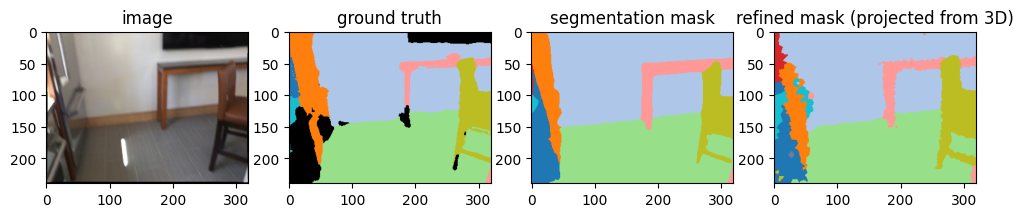

tensor([ 1,  1,  1,  ..., 14, 14,  0], dtype=torch.uint8)
tensor([[14, 14, 14,  ..., -1, -1, -1],
        [14, 14, 14,  ..., -1, -1, -1],
        [14, 14, 14,  ..., -1, -1, -1],
        ...,
        [-1, -1, -1,  ...,  6,  6,  6],
        [-1, -1, -1,  ...,  6,  6,  6],
        [-1, -1, -1,  ...,  6,  6,  6]])


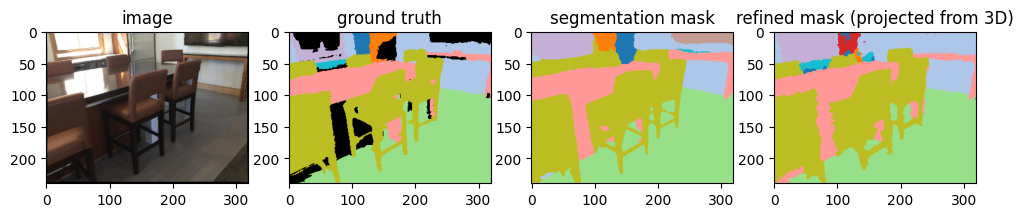

tensor([1, 1, 1,  ..., 8, 8, 8], dtype=torch.uint8)
tensor([[ 8,  8,  8,  ..., -1, -1, -1],
        [ 8,  8,  8,  ..., -1, -1, -1],
        [ 8,  8,  8,  ..., -1, -1, -1],
        ...,
        [-1, -1, -1,  ...,  1,  1, -1],
        [-1, -1, -1,  ...,  1,  1, -1],
        [-1, -1, -1,  ...,  1, -1, -1]])


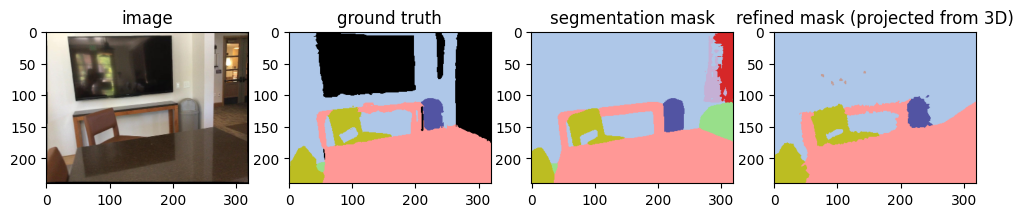

tensor([6, 6, 0,  ..., 0, 0, 0], dtype=torch.uint8)
tensor([[ 0,  0,  0,  ..., -1, -1, -1],
        [ 0,  0,  0,  ..., -1, -1, -1],
        [ 0,  0,  0,  ..., -1, -1, -1],
        ...,
        [ 4,  4,  4,  ...,  6,  6,  6],
        [ 4,  4,  4,  ...,  6,  6,  6],
        [ 4,  4,  4,  ...,  6,  6,  6]])


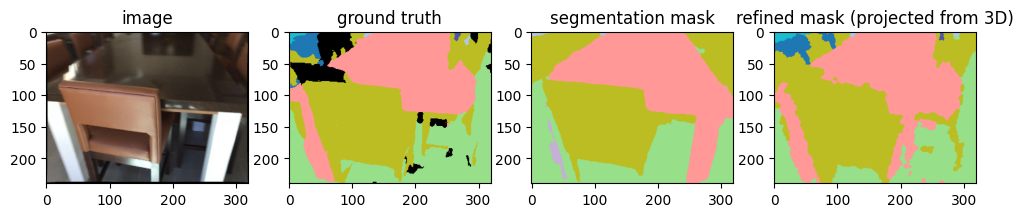

tensor([4, 4, 4,  ..., 4, 4, 4], dtype=torch.uint8)
tensor([[11, 11, 11,  ...,  4,  4,  4],
        [11, 11, 11,  ...,  4,  4,  4],
        [11, 11, 11,  ...,  4,  4,  4],
        ...,
        [ 1,  1,  1,  ...,  1,  1,  1],
        [ 1,  1,  1,  ...,  1,  1,  1],
        [ 1,  1,  1,  ...,  1,  1,  1]])


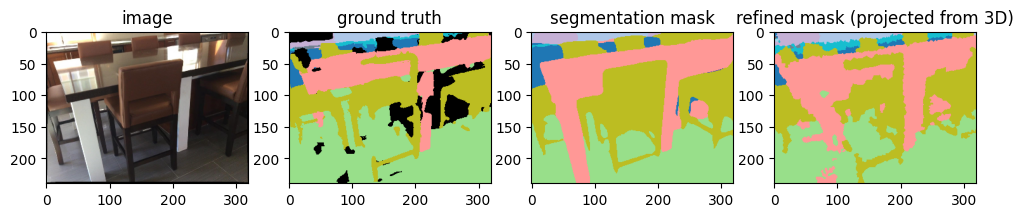

tensor([1, 1, 1,  ..., 8, 8, 8], dtype=torch.uint8)
tensor([[-1, -1, -1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1, -1],
        ...,
        [ 1,  1,  1,  ...,  1,  1,  1],
        [ 1,  1,  1,  ...,  1,  1,  1],
        [ 1,  1,  1,  ...,  1,  1,  1]])


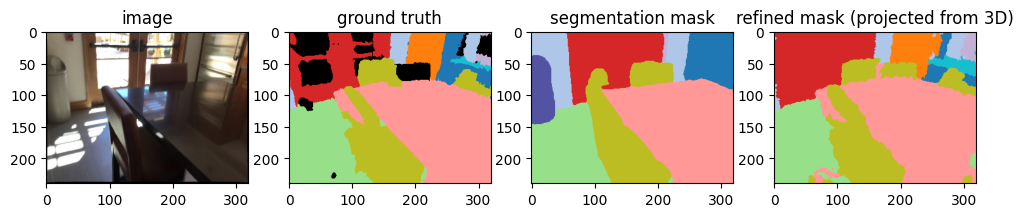

tensor([19, 19, 19,  ...,  2,  2,  2], dtype=torch.uint8)
tensor([[7, 7, 7,  ..., 8, 8, 8],
        [7, 7, 7,  ..., 8, 8, 8],
        [7, 7, 7,  ..., 8, 8, 8],
        ...,
        [1, 1, 1,  ..., 6, 6, 6],
        [1, 1, 1,  ..., 6, 6, 6],
        [1, 1, 1,  ..., 6, 6, 6]])


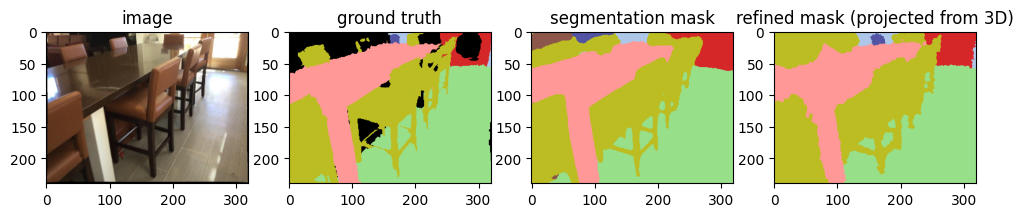

tensor([1, 1, 1,  ..., 4, 4, 4], dtype=torch.uint8)
tensor([[-1, -1, -1,  ...,  7,  7,  7],
        [-1, -1, -1,  ...,  7,  7,  7],
        [-1, -1, -1,  ...,  7,  7,  7],
        ...,
        [ 4,  4,  4,  ...,  1,  1,  1],
        [ 4,  4,  4,  ...,  1,  1,  1],
        [ 4,  4,  4,  ...,  1,  1,  1]])


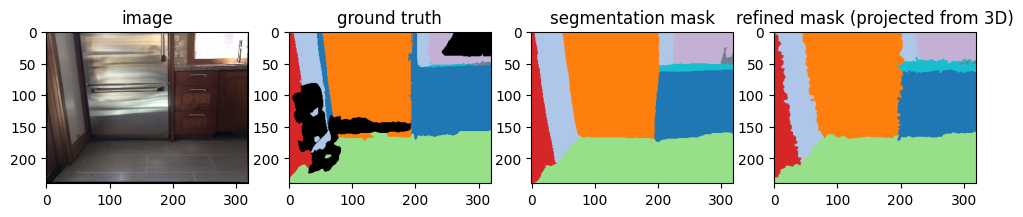

tensor([1, 1, 1,  ..., 8, 8, 0], dtype=torch.uint8)
tensor([[ 7,  7,  7,  ..., -1, -1, -1],
        [ 7,  7,  7,  ..., -1, -1, -1],
        [ 7,  7,  7,  ..., -1, -1, -1],
        ...,
        [ 1,  1,  1,  ...,  1,  1,  1],
        [ 1,  1,  1,  ...,  1,  1,  1],
        [ 1,  1,  1,  ...,  1,  1,  1]])


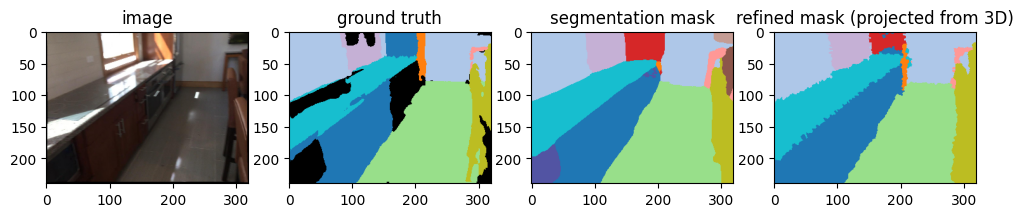

tensor([1, 1, 1,  ..., 0, 0, 0], dtype=torch.uint8)
tensor([[ 0,  0,  0,  ..., -1, -1, -1],
        [ 0,  0,  0,  ..., -1, -1, -1],
        [ 0,  0,  0,  ..., -1, -1, -1],
        ...,
        [-1, -1, -1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1, -1]])


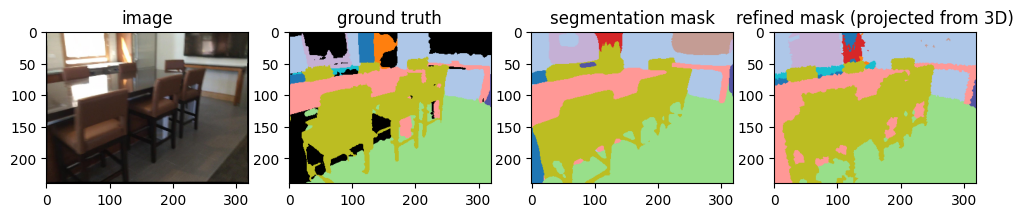

tensor([1, 1, 1,  ..., 7, 7, 8], dtype=torch.uint8)
tensor([[-1, -1, -1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1, -1],
        ...,
        [-1, -1, -1,  ...,  1,  1,  1],
        [-1, -1, -1,  ...,  1,  1,  1],
        [-1, -1, -1,  ...,  1,  1,  1]])


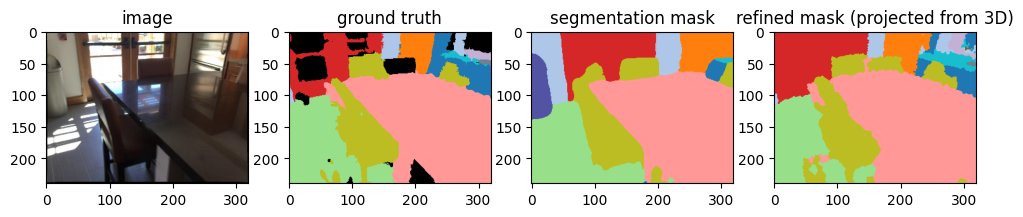

tensor([19, 19, 19,  ..., 14, 14, 14], dtype=torch.uint8)
tensor([[-1, -1, -1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1, -1],
        [ 7, -1, -1,  ..., -1, -1, -1],
        ...,
        [ 1,  1,  1,  ...,  6,  6,  6],
        [ 1,  1,  1,  ...,  6,  6,  6],
        [ 1,  1,  1,  ...,  6,  6,  6]])


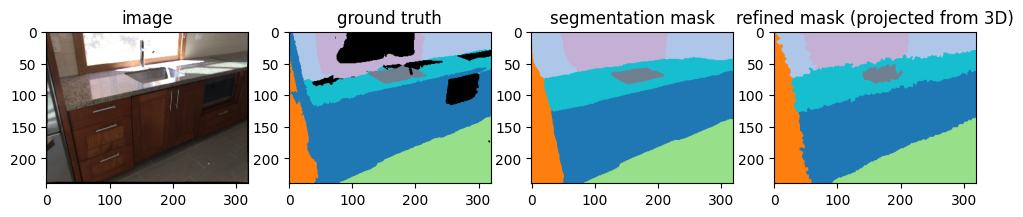

tensor([1, 1, 1,  ..., 8, 8, 0], dtype=torch.uint8)
tensor([[ 2,  2,  2,  ...,  0,  0,  0],
        [ 2,  2,  2,  ...,  0,  0,  0],
        [ 2,  2,  2,  ...,  0,  0,  0],
        ...,
        [14, 14, 14,  ...,  1,  1,  1],
        [14, 14, 14,  ...,  1,  1,  1],
        [14, 14, 14,  ...,  1,  1,  1]])


KeyboardInterrupt: 

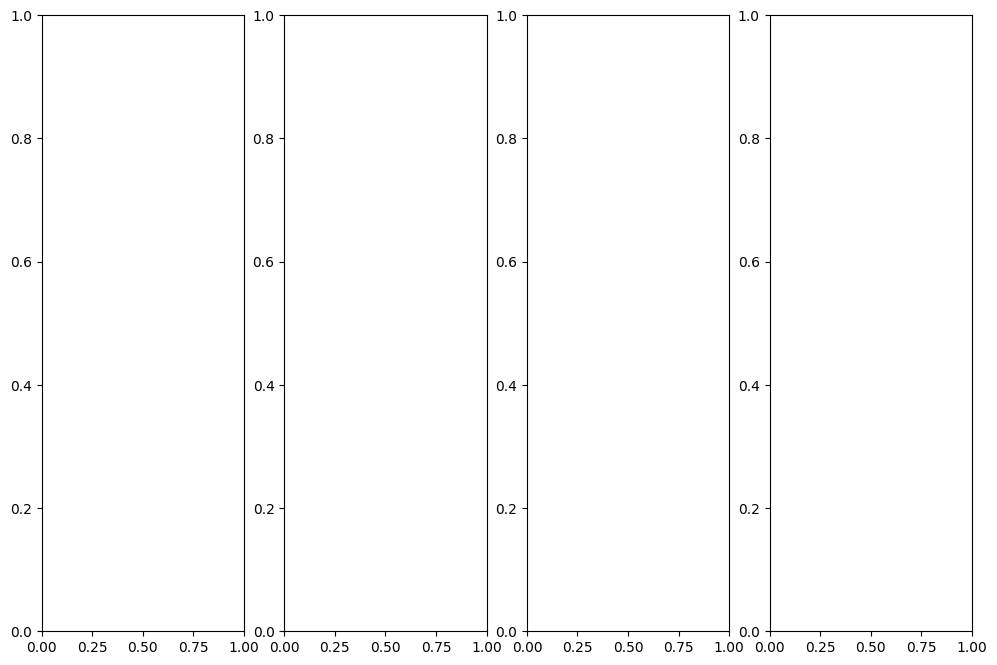

In [17]:
tracker_m2f.reset(stage='train')
tracker_mvfusion.reset(stage='train')

for sample_idx in range(3):
    mm_data = dataset.val_dataset[sample_idx]
    
    # Create a MMBatch and run inference
    batch = MMBatch.from_mm_data_list([mm_data])

    with torch.no_grad():
        print("input batch: ", batch)
        model.set_input(batch, model.device)
        model(batch)

    # Recover the predicted labels for visualization
    mm_data.data.pred = model.output.detach().cpu().argmax(1)

    mappings = mm_data.modalities['image'][0].mappings
    point_ids = torch.arange(
                    mappings.num_groups, device=mappings.device).repeat_interleave(
                    mappings.pointers[1:] - mappings.pointers[:-1])
    image_ids = mappings.images.repeat_interleave(
                    mappings.values[1].pointers[1:] - mappings.values[1].pointers[:-1])    
    pixels_full = mappings.pixels

    # Sort point and image ids based on image_id
    idx_sort = lexargsort(image_ids, point_ids)
    image_ids = image_ids[idx_sort]
    point_ids = point_ids[idx_sort]
    pixels_full = pixels_full[idx_sort].long()

    # Get pointers for easy indexing
    pointers = CSRData._sorted_indices_to_pointers(image_ids)

    # Loop over all N views
    for i, x in enumerate(mm_data.modalities['image'][0]):

        # Grab the 3D points corresponding to ith view
        start, end = pointers[i], pointers[i+1]    
        points = point_ids[start:end]
        pixels = pixels_full[start:end]
        # Image (x, y) pixel index
        w, h = pixels[:, 0], pixels[:, 1]

        # Grab set of points visible in current view
        mm_data_of_view = mm_data[points]

        # Get nearest neighbor interpolated projection image filled with 3D labels
        pred_mask_2d = -1 * torch.ones((240, 320), dtype=torch.long, device=mm_data_of_view.device)    
        pred_mask_2d[h, w] = mm_data_of_view.data.pred.squeeze()

        nearest_neighbor = scipy.ndimage.morphology.distance_transform_edt(
            pred_mask_2d==-1, return_distances=False, return_indices=True)    
        pred_mask_2d = pred_mask_2d[nearest_neighbor]

        # 2D mIoU calculation for M2F labels per view
        # Get gt 2d image
        gt_img_path = x.m2f_pred_mask_path[0].split("/")
        gt_img_path[-2] = 'label-filt-scannet20'
        gt_img_path = "/".join(gt_img_path)
        gt_img = Image.open(gt_img_path)
        gt_img = np.asarray(gt_img.resize((320, 240), resample=0)).astype(int) - 1   # -1 label offset
        gt_labels_2d = torch.LongTensor(gt_img[x.mappings.feature_map_indexing[2:]])

        # M2F predicted mask for current view
        m2f_labels_2d = x.get_mapped_m2f_features().squeeze()

        # color im
        im_path = x.m2f_pred_mask_path[0].split("/")
        im_path[-2] = 'color_resized'
        im_path = "/".join(im_path)
        im = Image.open(im_path)
        im = np.asarray(im.resize((320, 240), resample=0))
        
        # Visualizations
        f, axarr = plt.subplots(1,4, figsize=(12, 8)) 

        gt_img_rgb = np.array(list(map(lambda y: CLASS_COLORS[y], gt_img.flatten()))).reshape(240, 320, 3)
#         plt.imshow(gt_img_rgb.astype(int))
#         plt.show()

        pred_mask_2d_rgb = np.array(list(map(lambda y: CLASS_COLORS[y], pred_mask_2d.flatten()))).reshape(240, 320, 3)
#         plt.imshow(pred_mask_2d_rgb.astype(int))
#         plt.show()

        m2f_mask_2d_rgb = np.array(list(map(lambda y: CLASS_COLORS[y], x.m2f_pred_mask.flatten()))).reshape(240, 320, 3)
#         plt.imshow(m2f_mask_2d_rgb.astype(int))        
        
        # use the created array to output your multiple images. In this case I have stacked 4 images vertically
        axarr[0].imshow(im.astype(int))
        axarr[1].imshow(gt_img_rgb.astype(int))
        axarr[2].imshow(m2f_mask_2d_rgb.astype(int))
        axarr[3].imshow(pred_mask_2d_rgb.astype(int))
        
        axarr[0].set_title("image")
        axarr[1].set_title("ground truth")
        axarr[2].set_title("segmentation mask")
        axarr[3].set_title("refined mask (projected from 3D)")

        plt.show()
        
        break


        tracker_m2f.track(pred_labels=m2f_labels_2d, gt_labels=gt_labels_2d, model=None)
        tracker_m2f_2d.track(pred_labels=x.m2f_pred_mask[0][0], gt_labels=torch.LongTensor(gt_img), model=None)
        tracker_mvfusion.track(pred_labels=mm_data_of_view.data.pred, gt_labels=mm_data_of_view.data.y, model=None)
        tracker_mvfusion_2d.track(pred_labels=pred_mask_2d, gt_labels=torch.LongTensor(gt_img), model=None)


print("M2F mIoU of 3D projected points using 2D M2F pred label and 2D GT label: \n", tracker_m2f.get_metrics())
print("MVFusion 3D mIoU: \n", tracker_mvfusion.get_metrics())

print()
print("M2F 2D mIoU using pred mask and GT img: \n", tracker_m2f_2d.get_metrics())
print("MVFusion 2D projected nearest neighbor mIoU: \n", tracker_mvfusion_2d.get_metrics())



In [16]:
# visualize_mm_data(mm_data, class_names=CLASS_NAMES, class_colors=CLASS_COLORS, error_color=(0, 0, 0), front='y', back='x', figsize=1000, pointsize=3, voxel=0.05, show_2d=True, alpha=0.3)

### Multi-view consistency metric (Entropy)
- For each class in a scene, aggregate all predicted labels of all points belonging to that class from all views in which it is seen.
- In a scene, calculate the entropy of all predicted labels per class.
- Aggregate these per class entropy scores across all validation scenes to get multi-view entropy scores.



In [18]:
m2f_mode_entropy_tracker = ScannetSegmentationTracker(dataset=dataset, stage='train', wandb_log=False, use_tensorboard=False, ignore_label=IGNORE_LABEL)
m2f_viewpred_entropy_tracker = ScannetSegmentationTracker(dataset=dataset, stage='train', wandb_log=False, use_tensorboard=False, ignore_label=IGNORE_LABEL)
mvfusion_entropy_tracker = ScannetSegmentationTracker(dataset=dataset, stage='train', wandb_log=False, use_tensorboard=False, ignore_label=IGNORE_LABEL)


mm_data

MMData(
    data = Data(coords=[97387, 3], grid_size=[1], id_scan=[1], mapping_index=[97387], mvfusion_input=[72520, 9, 10], origin_id=[97387], pos=[97387, 3], pred=[97387], x=[97387, 3], y=[97387])
    image = ImageData(num_settings=1, num_views=100, num_points=97387, device=cpu)
)

In [19]:
m2f_mode_entropy_tracker.reset(stage='train')
mvfusion_entropy_tracker.reset(stage='train')
m2f_viewpred_entropy_tracker.reset(stage='train')

for sample_idx in range(3):

    mm_data = dataset.val_dataset[sample_idx]

    # Create a MMBatch and run inference
    batch = MMBatch.from_mm_data_list([mm_data])

    with torch.no_grad():
        model.set_input(batch, model.device)
        model(batch)

    # Recover the predicted labels for visualization
    mm_data.data.pred = model.output.detach().cpu().argmax(1)

    # This loop goes only once (actually not looping over all images, but processed everything at once)
    for i, x in enumerate(mm_data.modalities['image']):

        # M2F predicted mask for current view    
        #### Mode preds
        pixel_validity = mm_data.data.mvfusion_input[:, :, 0].bool()
        mv_preds = mm_data.data.mvfusion_input[:, :, -1].long()

        valid_m2f_feats = []
        for i in range(len(mv_preds)):
            valid_m2f_feats.append(mv_preds[i][pixel_validity[i]])

        ### IMPROVE by removing this loop and merging with previous loop
        mode_preds = []
        for m2feats_of_seen_point in valid_m2f_feats:
            mode_preds.append(torch.mode(m2feats_of_seen_point.squeeze(), dim=0)[0])
        mode_preds = torch.stack(mode_preds, dim=0)


        csr_idx = mm_data.modalities['image'][0].view_csr_indexing
        n_seen = csr_idx[1:] - csr_idx[:-1]
        seen_mask = ( n_seen > 0 )
        
        
        m2f_mode_entropy_tracker.track(pred_labels=mode_preds, gt_labels=mm_data.data.y[seen_mask], model=None)
        mvfusion_entropy_tracker.track(pred_labels=mm_data.data.pred[seen_mask], gt_labels=mm_data.data.y[seen_mask], model=None)

        # Instead of mode preds, add all M2F preds within mvfusion_input. Duplicate gt labels to be able to evaluate.
        seen_labels = mm_data.data.y[seen_mask]
        duplicated_gt_labels = []
        for i, m2f_feats_of_point in enumerate(valid_m2f_feats):
            duplicated_gt_labels.extend([seen_labels[i].item()] * len(m2f_feats_of_point))
            

        valid_m2f_feats = torch.cat(valid_m2f_feats, dim=-1).tolist()
        
        m2f_viewpred_entropy_tracker.track(pred_labels=torch.LongTensor(valid_m2f_feats),
                                           gt_labels=torch.LongTensor(duplicated_gt_labels), model=None)
        
            
        
        
print(m2f_mode_entropy_tracker.get_metrics())
print(mvfusion_entropy_tracker.get_metrics())
print(m2f_viewpred_entropy_tracker.get_metrics())

tensor([1, 1, 1,  ..., 0, 0, 0])
[1, 1, 6, 1, 1, 6, 1, 1, 19, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([1, 1, 0,  ..., 0, 2, 0])
[1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([1, 1, 1,  ..., 0, 0, 0])
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
{'train_acc': 89.24399681288179, 'train_macc': 83.44342992649281, 'train_miou': 49.209426409079654}
{'train_acc': 94.7277149091515, 'train_macc': 88.77859864112395, 'train_miou': 66.5290880767561}
{'train_acc': 87.37669839822357, 'train_macc': 79.92863987642941, 'train_miou': 44.872960735085535}


In [23]:
confusion_mat = m2f_viewpred_entropy_tracker._confusion_matrix.get_confusion_matrix()

per_class_normalized_entropy = []
for i in range(len(confusion_mat)):
    nonzero_entries = confusion_mat[:, i][confusion_mat[:, i] > 0]
#     print( nonzero_entries )
    
    # normalized entropy using log2 base
    pk = nonzero_entries / nonzero_entries.sum()
    
    if len(pk) <= 1:
        per_class_normalized_entropy.append(0.)
    else:
        normalized_entropy = -sum(pk * np.log2(pk)) / np.log2(len(pk))
        per_class_normalized_entropy.append(normalized_entropy)
        
print(np.mean(np.array(per_class_normalized_entropy)))

# MVFusion predicted 3d points: 0.1440264225076999
# M2F mode pred 3d points: 0.17243167203189816
# M2F view pred as 3d points (sampled more points): 0.28071956009032795

0.28071956009032795


In [ ]:
def calculate_multiview_inconsistency(masks=None, pp_mapping=None, pixel_validity=None, interpol_mask_labels=None, gt_mask_labels=None, gt_3d_labels=None):
    # transpose for ease
    interpol_mask_labels = interpol_mask_labels.T
    gt_mask_labels = gt_mask_labels.T
    
    total_entropy = 0.
    gt_total_entropy = 0.
    n_multiview_points = 0
    
    # when x was the mode label, how many other views predicted x wrongly
    barplot_n_mistakes_in_other_views = np.zeros(20)
    gt_barplot_n_mistakes_in_other_views = np.zeros(20)
    
    for i in range(interpol_mask_labels.shape[0]):
        # don't evaluate invalid gt class
        if not gt_3d_labels[i] == 0:
            labels, label_counts = torch.unique(interpol_mask_labels[i], return_counts=True, sorted=True)
            gt_labels, gt_label_counts = torch.unique(gt_mask_labels[i], return_counts=True, sorted=True)

            if labels[0] == 0.:
                labels = labels[1:]
                label_counts = label_counts[1:]
                
            if gt_labels[0] == 0.:
                gt_labels = gt_labels[1:]
                gt_label_counts = gt_label_counts[1:]

            # evaluate inconsistency if point is seen in more than 1 view
            if label_counts.sum() > 1:
#                 p_tensor = label_counts
#                 gt_p_tensor = gt_label_counts

                # normalized entropy using log2 base
                pk = label_counts / label_counts.sum()
                normalized_entropy = -sum(pk * torch.log2(pk)) / torch.log2(torch.tensor(len(pk)))

                gt_pk = gt_label_counts / gt_label_counts.sum()
                gt_normalized_entropy = -sum(gt_pk * torch.log2(gt_pk)) / torch.log2(torch.tensor(len(gt_pk)))
                
#                 entropy = Categorical(probs = p_tensor).entropy()
#                 gt_entropy = Categorical(probs = gt_p_tensor).entropy()
                
                barplot_n_mistakes_in_other_views[int(labels[0]-1)] += normalized_entropy
                gt_barplot_n_mistakes_in_other_views[int(gt_labels[0]-1)] += gt_normalized_entropy
                
                n_multiview_points += 1
                total_entropy += normalized_entropy
                gt_total_entropy += gt_normalized_entropy
                
    return (total_entropy / n_multiview_points, n_multiview_points, barplot_n_mistakes_in_other_views / n_multiview_points), (gt_total_entropy / n_multiview_points, n_multiview_points, gt_barplot_n_mistakes_in_other_views / n_multiview_points)

In [ ]:
mm_data

In [ ]:
from PIL import Image
import os

label_unique = set()
for n in os.listdir("/project/fsun/data/scannet/scans/scene0000_00/swin_l_early"):
    a = Image.open(f"/project/fsun/data/scannet/scans/scene0000_00/swin_l_early/{n}")
    label_unique.update(list(np.unique(np.array(a)))) 
print(label_unique)

In [ ]:
label_unique = set()
for n in os.listdir("/project/fsun/data/scannet/scans/scene0000_00/m2f_masks"):
    a = Image.open(f"/project/fsun/data/scannet/scans/scene0000_00/m2f_masks/{n}")
    label_unique.update(list(np.unique(np.array(a)))) 
print(label_unique)

In [ ]:
mm_data = dataset.train_dataset[0]
mm_data

### Compare mapping feature statistics between train/val/test proccessed_2d 

In [ ]:
for split in ['train', 'val', 'test']:
    data_dir = f"/project/fsun/dvata/scannet-neucon-smallres-m2f/processed/processed_2d_{split}"

    mean = 0
    std = 0
    for name in os.listdir(data_dir):
        file = osp.join(data_dir, name)

        data = torch.load(file)
        data = data._mappings.values[2]

        # note that estimation is biased
        mean += data.mean(axis=0)
        std += data.std(axis=0)
        
    mean /= len(os.listdir(data_dir))
    std /= len(os.listdir(data_dir))


    print(f"{split} mapping feature statistics:")
    print(mean)
    print(std)    



In [77]:
# Set your dataset root directory, where the data was/will be downloaded
DATA_ROOT = '/project/fsun/dvata'

dataset_config = 'segmentation/multimodal/Feng/scannet-neucon-smallres-m2f-partial-subsampled'   
models_config = 'segmentation/multimodal/Feng/mvfusion'    # model family
model_name = 'MVFusion_3D_small'                       # specific model

# models_config = 'segmentation/multimodal/Feng/3d_only'    # model family
# model_name = 'Res16UNet34'                       # specific model



# dataset_config = 'segmentation/multimodal/scannet-sparse'
# models_config = 'segmentation/multimodal/sparseconv3d'    # model family
# model_name = 'Res16UNet34-L4-early'                       # specific model

overrides = [
    'task=segmentation',
    f'data={dataset_config}',
    f'models={models_config}',
    f'model_name={model_name}',
    f'data.dataroot={DATA_ROOT}',
]

cfg = hydra_read(overrides)
OmegaConf.set_struct(cfg, False)  # This allows getattr and hasattr methods to function correctly
# cfg.data.load_m2f_masks = True   # load Mask2Former predicted masks

cfg.data.load_m2f_masks = True   # load Mask2Former predicted masks

In [79]:
cfg.data.m2f_preds_dirname = 'm2f_masks'
cfg.data.n_views = 9 #cfg.models[model_name].backbone.transformer.n_views
print(cfg.data.n_views)

9


In [80]:
# Dataset instantiation
start = time()
dataset = ScannetDatasetMM(cfg.data)
# print(dataset)|
print(f"Time = {time() - start:0.1f} sec.")

Load predicted 2D semantic segmentation labels from directory  m2f_masks
initialize train dataset
initialize val dataset
initialize test dataset
line 720 scannet.py: split == 'test'
Time = 1.4 sec.


## Run inference from pretrained weights and visualize predictions
It is possible to visualize the pointwise predictions and errors from a model. 

To do so, we will use the pretrained weights made available with this project. See `README.md` to get the download links and manually place the `.pt` files locally. You will need to provide `checkpoint_dir` where you saved those files in the next cell.

In [87]:
from torch_points3d.models.model_factory import instantiate_model

# Set your parameters
# checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/2022-12-04/15-22-16' # MVFusion_3D_small default m2f_masks
checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/2022-12-07/12-07-34' # 3rd run

        
# # checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/2022-12-04/15-48-56' # MVFusion_3D_small default swin_l_early


# checkpoint_dir = '/project/fsun/DeepViewAgg/outputs/2022-11-04/15-51-33' # 3D Backbone, 68.04 miou
# checkpoint_dir = '/home/fsun/DeepViewAgg/model_checkpoints' # DVA best model

# Create the model
print(f"Creating model: {cfg.model_name}")
model = instantiate_model(cfg, dataset)
# print(model)

# Load the checkpoint and recover the 'best_miou' model weights
checkpoint = torch.load(f'{checkpoint_dir}/{model_name}.pt', map_location='cpu')
model.load_state_dict_with_same_shape(checkpoint['models']['latest'], strict=False)

# Prepare the model for inference
model = model.eval().cuda()
print('Model loaded')

Creating model: MVFusion_3D_small
task:  segmentation.multimodal
tested_model_name:  MVFusion_3D_small
class_name:  MVFusionAPIModel
model_module:  torch_points3d.models.segmentation.multimodal.Feng.mvfusion_3d
name, cls of chosen model_cls:  MVFusionAPIModel <class 'torch_points3d.models.segmentation.multimodal.Feng.mvfusion_3d.MVFusionAPIModel'>
x feature dim:  {'FEAT': 3}
nc_in:  67
nc_in:  64
nc_in:  32
nc_in:  64
nc_in:  128
nc_in:  256
nc_in:  128
nc_in:  128
nc_in:  96
nc_in:  96
Model loaded


Now we have loaded the model, we need to run a forward pass on a sample. Howver, if we want to be able to visualize the predictions, we need to pay special attention to which type of 3D and 2D transforms we apply on the data if we do not want to break the mappings. To do so, we will manually apply some sensitive transforms to be able to both infer on the data and visualize it.

In [22]:
i_room = 0

# Pick a room in the Train set
mm_data = sample_real_data(dataset.train_dataset, idx=i_room, exclude_3d=exclude_3d_viz, exclude_2d=exclude_2d_viz)

# Pick a room in the Val set
# mm_data = sample_real_data(dataset.val_dataset, idx=i_room, exclude_3d=exclude_3d_viz, exclude_2d=exclude_2d_viz)

# Pick a room in the Test set
# mm_data = sample_real_data(dataset.test_dataset[0], idx=i_room, exclude_3d=exclude_3d_viz, exclude_2d=exclude_2d_viz)

# Extract point cloud and images from MMData object
data = mm_data.data.clone()
images = mm_data.modalities['image'].clone()

data

NameError: name 'sample_real_data' is not defined

In [23]:
# Run cell for validation sample with original validation transformations
mm_data = dataset.val_dataset[0]

# data = mm_data.data.clone()
# images = mm_data.modalities['image'].clone()
# data

In [ ]:
mm_data

In [ ]:
# For voxel-based 3D backbones such as SparseConv3d and MinkowskiNet, points need to be 
# preprocessed with Center and GridSampling3D. Unfortunately, Center breaks relative 
# positions between points and images. Besides, the combination of Center and GridSampling3D
# may lead to some points being merged into the same voxels, so we must apply it to both the
# inference and visualization data to make sure we have the same voxels. The workaround here 
# is to manually run these while keeping track of the centering offset
center = data.pos.mean(dim=-2, keepdim=True)
data = AddFeatsByKeys(list_add_to_x=[True, True, True], feat_names=['pos_x', 'pos_y', 'pos_z'], delete_feats=[True, True, True])(data)          # add z-height to the features
data = Center()(data)                                                                                 # mean-center the data
data = GridSampling3D(cfg.data.resolution_3d, quantize_coords=True, mode='last')(data)                # quantization for volumetric models

# This last voxelization step with GridSampling3D might have removed some points, so we need
# to update the mappings usign SelectMappingFromPointId. To control the size of the batch, we
# use PickImagesFromMemoryCredit. Besides, 2D models expect normalized float images, which is
# why we call ToFloatImage and Normalize
data, images = SelectMappingFromPointId()(data, images)                                               # update mappings after GridSampling3D
data, images = PickImagesFromMemoryCredit(
    img_size=cfg.data.resolution_2d, 
    k_coverage=cfg.data.multimodal.settings.k_coverage, 
    n_img=cfg.data.multimodal.settings.test_pixel_credit)(data, images)                                      # select images to respect memory constraints
data, images_infer = ToFloatImage()(data, images.clone())                                             # convert uint8 images to float
data, images_infer = Normalize()(data, images_infer)                                                  # RGB normalization

# Create a MMData for inference
mm_data_infer = MMData(data, image=images_infer)
print(mm_data_infer)

# Create a MMBatch and run inference
batch = MMBatch.from_mm_data_list([mm_data_infer])

with torch.no_grad():
    print("input batch: ", batch)
    model.set_input(batch, model.device)
    model(batch)

# Create a MMData for visualization
data.pos += center
mm_data = MMData(data, image=images)

# Recover the predicted labels for visualization
mm_data.data.pred = model.output.detach().cpu().argmax(1)

In [88]:
# Run inference with augmentations
# mm_data = dataset.train_dataset[0]
mm_data = dataset.val_dataset[0]
# mm_data = dataset.test_dataset[0][0]

# Create a MMBatch and run inference
batch = MMBatch.from_mm_data_list([mm_data])

with torch.no_grad():
    print("input batch: ", batch)
    model.set_input(batch, model.device)
    model(batch)
    
# Recover the predicted labels for visualization
mm_data.data.pred = model.output.detach().cpu().argmax(1)

input batch:  MMBatch(
    data = Batch(batch=[97387], coords=[97387, 3], grid_size=[1], id_scan=[1], mapping_index=[97387], mvfusion_input=[70411, 9, 10], origin_id=[97387], pos=[97387, 3], ptr=[2], x=[97387, 3], y=[97387])
    image = ImageBatch(num_settings=1, num_views=100, num_points=97387, device=cpu)
)


In [89]:
CLASS_COLORS[0] = (174.0, 199.0, 232.0)
CLASS_COLORS[-1] = (0, 0, 0)
# CLASS_COLORS

In [90]:
print(mm_data.data)
mm_data.modalities['image'] = None
mm_data

Data(coords=[97387, 3], grid_size=[1], id_scan=[1], mapping_index=[97387], mvfusion_input=[70411, 9, 10], origin_id=[97387], pos=[97387, 3], pred=[97387], x=[97387, 3], y=[97387])


MMData(
    data = Data(coords=[97387, 3], grid_size=[1], id_scan=[1], mapping_index=[97387], mvfusion_input=[70411, 9, 10], origin_id=[97387], pos=[97387, 3], pred=[97387], x=[97387, 3], y=[97387])
    image = None
)

In [44]:
# fig = visualize_mm_data(mm_data, no_output=True, figsize=1000, pointsize=3, voxel=0.05, show_2d=False, back='x', front='y', class_names=CLASS_NAMES, class_colors=CLASS_COLORS, alpha=0.3)

In [ ]:
### Select seen points
csr_idx = mm_data.modalities['image'][0].view_csr_indexing
dense_idx_list = torch.arange(mm_data.modalities['image'][0].num_points).repeat_interleave(csr_idx[1:] - csr_idx[:-1])
# take subset of only seen points without re-indexing the same point
mm_data = mm_data[dense_idx_list.unique()]


In [ ]:
def get_mode_pred(data):
    pixel_validity = data.data.mvfusion_input[:, :, 0].bool()
    mv_preds = data.data.mvfusion_input[:, :, -1].long()
            
    valid_m2f_feats = []
    for i in range(len(mv_preds)):
        valid_m2f_feats.append(mv_preds[i][pixel_validity[i]])

    mode_preds = []
    for m2feats_of_seen_point in valid_m2f_feats:
        mode_preds.append(torch.mode(m2feats_of_seen_point.squeeze(), dim=0)[0])
    mode_preds = torch.stack(mode_preds, dim=0)
        
    return mode_preds

mode_preds = get_mode_pred(mm_data)

In [ ]:
print(mode_preds.shape)
print(mm_data.data.pred.shape)

In [ ]:
m2f_mm_data = mm_data.clone()
m2f_mm_data.data.x = None
m2f_mm_data.data.pred = mode_preds
# m2f_mm_data.data.pred = m2f_mm_data.data.pred[m2f_mm_data.data.y != -1]
m2f_mm_data = m2f_mm_data[m2f_mm_data.data.y != -1]

visualize_mm_data(m2f_mm_data, figsize=1000, pointsize=3, voxel=0.05, show_2d=False, back='m2f_mask_pred', front='y', class_names=CLASS_NAMES, class_colors=CLASS_COLORS, alpha=0.3)

In [ ]:
mm_data.data.x = None
mm_data.data.pred = mm_data.data.pred[mm_data.data.y != -1]
mm_data = mm_data[mm_data.data.y != -1]


print(mm_data.data.pred.unique())
mm_data.data.y.unique()

In [ ]:
visualize_mm_data(mm_data, figsize=1000, pointsize=3, voxel=0.05, show_2d=False, back='m2f_pred_mask', front='y', class_names=CLASS_NAMES, class_colors=CLASS_COLORS, alpha=0.3)

# Swin_l_early masks

In [ ]:
m2f_mm_data = mm_data.clone()
m2f_mm_data.data.x = None
m2f_mm_data.data.pred = mode_preds
# m2f_mm_data.data.pred = m2f_mm_data.data.pred[m2f_mm_data.data.y != -1]
m2f_mm_data = m2f_mm_data[m2f_mm_data.data.y != -1]

visualize_mm_data(m2f_mm_data, figsize=1000, pointsize=3, voxel=0.05, show_2d=False, back='m2f_mask_pred', front='y', class_names=CLASS_NAMES, class_colors=CLASS_COLORS, alpha=0.3)

In [ ]:
visualize_mm_data(mm_data, figsize=1000, pointsize=3, voxel=0.05, show_2d=False, back='m2f_pred_mask', front='y', class_names=CLASS_NAMES, class_colors=CLASS_COLORS, alpha=0.3)

In [ ]:
### Calculate number of correct predictions (accuracy)

print(sum(mm_data.y == mm_data.pred) / len(mm_data.y))

print(sum(m2f_mm_data.y == m2f_mm_data.pred) / len(m2f_mm_data.y))


In [ ]:
i_room = 0

# Pick a room in the Train set
mm_data = sample_real_data(dataset.train_dataset, idx=i_room, exclude_3d=exclude_3d_viz, exclude_2d=exclude_2d_viz)

# Pick a room in the Val set
# mm_data = sample_real_data(dataset.val_dataset, idx=i_room, exclude_3d=exclude_3d_viz, exclude_2d=exclude_2d_viz)

# Pick a room in the Test set
# mm_data = sample_real_data(dataset.test_dataset[0], idx=i_room, exclude_3d=exclude_3d_viz, exclude_2d=exclude_2d_viz)

# Extract point cloud and images from MMData object
data = mm_data.data.clone()
images = mm_data.modalities['image'].clone()

data

In [ ]:
mm_data = dataset.train_dataset[0]

In [ ]:
### Select seen points
csr_idx = mm_data.modalities['image'][0].view_csr_indexing
dense_idx_list = torch.arange(mm_data.modalities['image'][0].num_points).repeat_interleave(csr_idx[1:] - csr_idx[:-1])
# take subset of only seen points without re-indexing the same point
mm_data = mm_data[dense_idx_list.unique()]

In [ ]:
mode_preds = get_mode_pred(mm_data)
m2f_mm_data = mm_data.clone()
m2f_mm_data.data.x = None
m2f_mm_data.data.pred = mode_preds
# m2f_mm_data.data.pred = m2f_mm_data.data.pred[m2f_mm_data.data.y != -1]
m2f_mm_data = m2f_mm_data[m2f_mm_data.data.y != -1]

visualize_mm_data(m2f_mm_data, figsize=1000, pointsize=3, voxel=0.05, show_2d=False, back='m2f_mask_pred', front='y', class_names=CLASS_NAMES, class_colors=CLASS_COLORS, alpha=0.3)

In [ ]:
mode_preds = get_mode_pred(mm_data)
m2f_mm_data = mm_data.clone()
m2f_mm_data.data.x = None
m2f_mm_data.data.pred = mode_preds
# m2f_mm_data.data.pred = m2f_mm_data.data.pred[m2f_mm_data.data.y != -1]
m2f_mm_data = m2f_mm_data[m2f_mm_data.data.y != -1]

visualize_mm_data(m2f_mm_data, figsize=1000, pointsize=3, voxel=0.05, show_2d=False, back='m2f_mask_pred', front='y', class_names=CLASS_NAMES, class_colors=CLASS_COLORS, alpha=0.3)